# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report


# Load Data

In [2]:
#CIFAR-10 is built into Keras, so we can load it directly.
# Load data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test images shape: ',test_images.shape)
print('Test labels shape: ',test_labels.shape)

Train images shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test images shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


##  Limiting the Training Data

To save training time and reduce computational load, we are limiting the training data to 10,000 samples. This is especially helpful if working on a local machine or using a free tier cloud service like Google Colab. There is no need to limit the testing portion of data because it is 10k images by default.

In [3]:
# Only use 10,000 images for training (to save time)
n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]

print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)

# just see the first image on train data
train_images[0]

Train images shape:  (10000, 32, 32, 3)
Train labels shape:  (10000, 1)


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [ ]:

#n = 20000
#train_images = train_images[:n]
#train_labels = train_labels[:n]

Label 0: 1005
Label 1: 974
Label 2: 1032
Label 3: 1016
Label 4: 999
Label 5: 937
Label 6: 1030
Label 7: 1001
Label 8: 1025
Label 9: 981


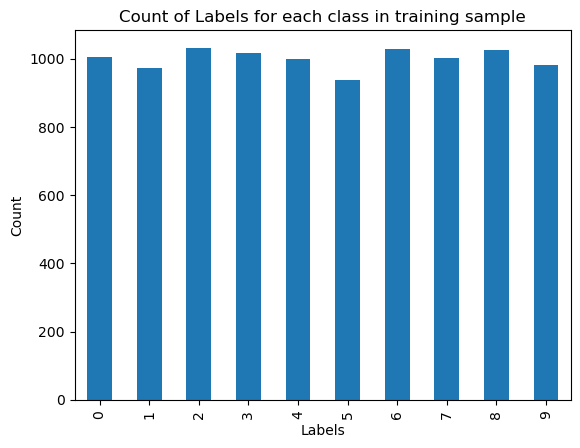

In [5]:
# Flatten the labels
flattened_array = train_labels.flatten()

# Count values and sort by label in ascending order
label_counts = pd.Series(flattened_array).value_counts().sort_index()

# Print value count of labels
for label, count in label_counts.items():
    print(f"Label {label}: {count}")

# Print unique label and counts in ascending order
label_counts.plot(kind='bar')
plt.title('Count of Labels for each class in training sample')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Visualization : Understanding the Training Images and Classes
The CIFAR-10 dataset consists of 60,000 color images, each sized 32x32 pixels, divided into 10 distinct classes. Visualizing sample images from each class helps us understand the diversity and complexity of the data, ensures that the dataset is loaded correctly, and confirms that the labels correspond to the images.


In the documentation for the `cifar10.load_data()` function we can see that each numerical class is associated with a concrete class as below:

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

In [6]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

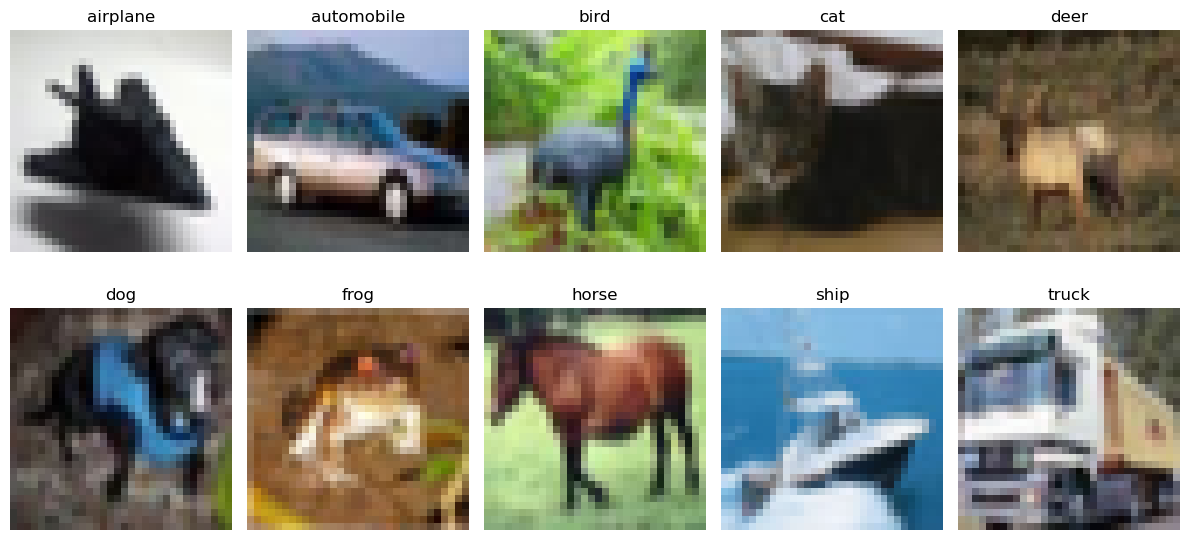

In [7]:
# Show One Image per Class from CIFAR-10

# Create a list to store one image per class
images_to_show = []
labels = train_labels.flatten()

# Loop through the dataset to find one image for each class (0 to 9)
for class_index in range(10):
    for i in range(len(labels)):
        if labels[i] == class_index:
            images_to_show.append(train_images[i])
            break  # Stop after finding the first image for this class

# Now, display these images
plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create 2 rows and 5 columns of plots
    plt.imshow(images_to_show[i])  # Show the image
    plt.title(class_name[i])      # Show the class name
    plt.axis('off')                # Hide axis
plt.tight_layout()
plt.show()

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_21925/1001136431.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(train_labels[i])


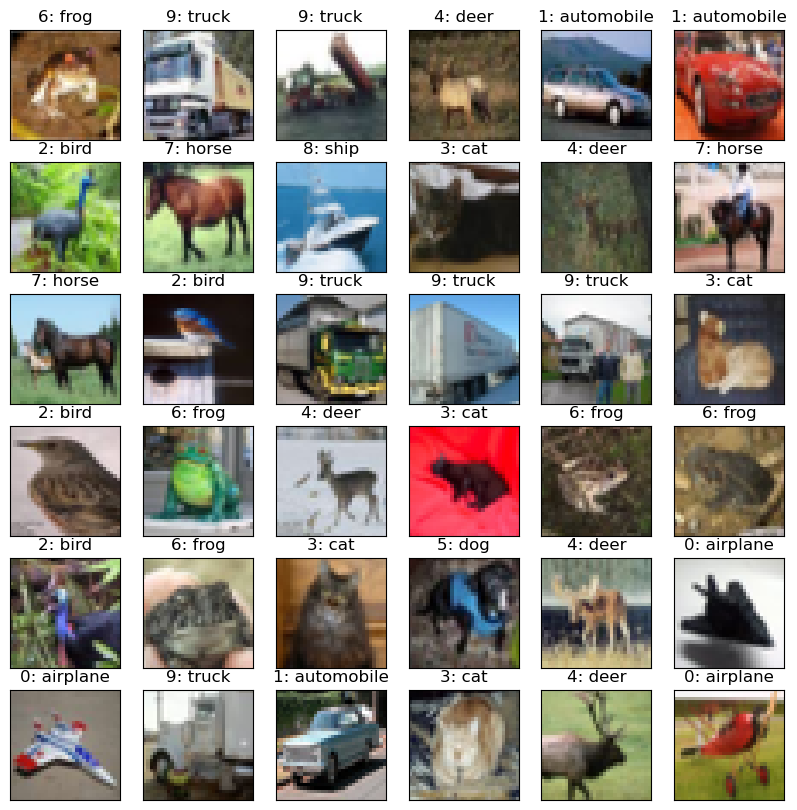

In [8]:
#Visualize first 36 training images with their label numbers and class names as titles, to quickly see samples and verify labels visually.
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    label_index = int(train_labels[i])
    plt.title(f"{label_index}: {class_name[label_index]}")
plt.show()

# Preprocess the Images

Before training a neural network, it's important to prepare the data so that the model can learn effectively. In this step, we performed two key preprocessing techniques: Normalization and One-Hot Encoding of Labels

## Normalization:
Raw pixel values in images range from 0 to 255. Neural networks learn faster and more efficiently when inputs are on a smaller scale.
We normalized the images by dividing each pixel value by 255, so all pixel values now range between 0 and 1.

In [9]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

print(train_images.shape)


(10000, 32, 32, 3)


## One-Hot Encoding of Labels
The labels in the CIFAR-10 dataset are integers from 0 to 9, each representing a different class (like 'cat', 'dog', etc.).
To use them in classification with neural networks, we converted these integer labels into one-hot encoded vectors.

In [10]:
# One-hot encode labels
print('Before encoding the train labels: ', train_labels)

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print('After encoding the train labels: ', train_labels)
print('Train labels shape: ',train_labels.shape)
print('Train labels shape: ', test_labels.shape)



Before encoding the train labels:  [[6]
 [9]
 [9]
 ...
 [1]
 [1]
 [5]]
After encoding the train labels:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Train labels shape:  (10000, 10)
Train labels shape:  (10000, 10)


# Convolutional Neural Network (CNN)

A CNN is a deep learning model designed for image classification and computer vision tasks. It automatically learns to detect visual patterns like edges, shapes, and textures using layers such as convolutional layers (for feature detection), pooling layers (for reducing image size), and fully connected layers (for making predictions).

In this project, we used ResNet50, a powerful pre-trained CNN with 50 layers that includes skip connections to improve learning in deep networks. By applying Transfer Learning, we reused ResNet50 (originally trained on the large ImageNet dataset), froze its base layers, and added custom layers to classify CIFAR-10 images. This approach improves accuracy and saves training time.


## Initialize Base Model

Using a pretrained ResNet50 (ImageNet), we remove the top layers of original classification layers by include_top=False and freeze it to keep weights unchanged during the first training phase

In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the base model

## Building the Top of the Model

we create a new model by stacking a pre-trained base model (ResNet50) with additional custom layers on top. The base model extracts important features from the images, while the custom layers act as a classifier to decide which of the 10 classes each image belongs to.



* GlobalAveragePooling2D: Converts 3D feature maps into a 1D vector by averaging, reducing data size for dense layers.

* Dense Layers:

    1st: 256 neurons with ReLU activation to learn complex features.

    2nd: 128 neurons with ReLU for deeper learning.

* Dropout: Randomly disables 50% of neurons during training to prevent overfitting.

* Output Layer: 10 neurons with softmax activation for class probabilities (CIFAR-10 classes).

In [12]:
#Base Model + Custom Classification Layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Converts 3D feature maps to 1D vector.
    layers.Dense(256, activation='relu'),   # First hidden layer
    layers.Dense(128, activation='relu'),   # Second hidden layer
    layers.Dropout(0.5),                    # Prevents overfitting by randomly dropping neurons
    layers.Dense(10, activation='softmax')  # Output layer: 10 class
])

In [13]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile the Model

* Optimizer: Adam optimizer, which helps the model learn by adjusting weights efficiently.

* Loss function: categorical_crossentropy, used because we have multiple classes (10 classes in CIFAR-10)

* Metric: Accuracy, to measure how well the model is performing during training.

In [14]:
# Compile the model with optimizer, loss function and metrices
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Top Layers of the Model
We train only the custom layers that we added on top of the pre-trained base model. The base model is frozen, meaning its weights are not updated during this phase.

We also use EarlyStopping, which stops training if the validation loss doesn’t improve for 5 consecutive epochs to prevent overfitting and saves time.

In [15]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history =model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images,
                    test_labels),
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.0938 - loss: 2.4325 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.0926 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.1007 - loss: 2.3023 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.1042 - loss: 2.3022 - val_accuracy: 0.1002 - val_loss: 2.3028
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.1058 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.1026 - loss: 2.3023 - val_accuracy: 0.0998 - val_loss: 2.3027


## Model Evaluation & Training Performance
We evaluate its performance on the unseen test dataset using accuracy and loss metrics.

* Test Accuracy: Measures how well the model performs on new data.

* Test Loss: Reflects how far the model's predictions are from the true labels  — lower is better.

In [16]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy for Base Model: {test_accuracy:.2f}")
print(f"Test loss for Base Model: {test_loss:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.1036 - loss: 2.3025
Test accuracy for Base Model: 0.10
Test loss for Base Model: 2.30


We also visualize the model's training history:

* Loss Curve shows how the error decreased during training and validation.

* Accuracy Curve shows how prediction performance improved over time.

Text(0.5, 1.0, 'Accuracy')

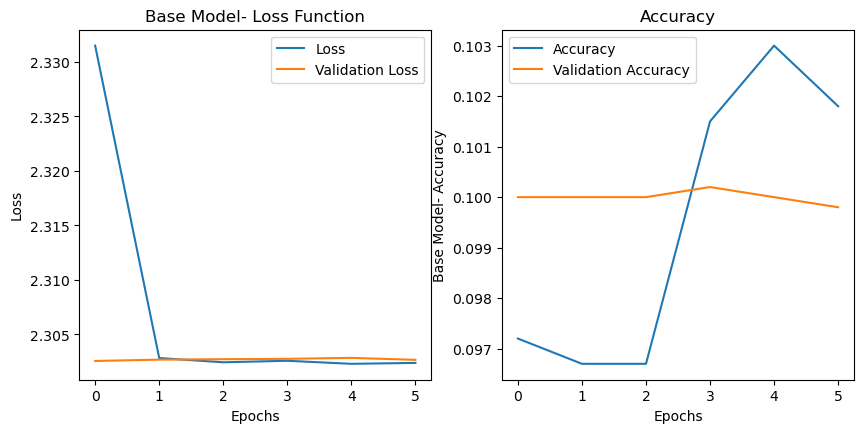

In [17]:
#These plots help evaluate if the model is learning effectively and when to stop training (e.g., with early stopping).
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')    # Y-axis label
plt.legend()
plt.title('Base Model- Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Base Model- Accuracy')  # Y-axis label
plt.legend()
plt.title('Accuracy')

# Model Improvement Strategy

we experiment with adding more layers and increasing the number of training epochs to see if we can improve the model's performance. These changes aim to help the model learn better patterns from the training data and generalize well on unseen data.



In [18]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Converts 3D feature maps to 1D vector.
    layers.Dense(256, activation='relu'),   # First hidden layer
    layers.Dense(128, activation='relu'),   # Second hidden layer
    layers.Dense(64, activation='relu'),    # Third hidden layer
    layers.Dropout(0.5),                    # Prevents overfitting by randomly dropping neurons
    layers.Dense(10, activation='softmax')  # Output layer: 10 class
])

# Compile the model with optimizer, loss function and metrices
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Train model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history_improved =model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(test_images,
                    test_labels),
    callbacks=[early_stop]
)



Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.1091 - loss: 2.3473 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.1043 - loss: 2.3023 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.0992 - loss: 2.3024 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.1000 - loss: 2.3024 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.1006 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.1002 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3029


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1006 - loss: 2.3026
Test accuracy after model improvement: 0.10
Test loss after model improvement: 2.30


Text(0.5, 1.0, 'Accuracy')

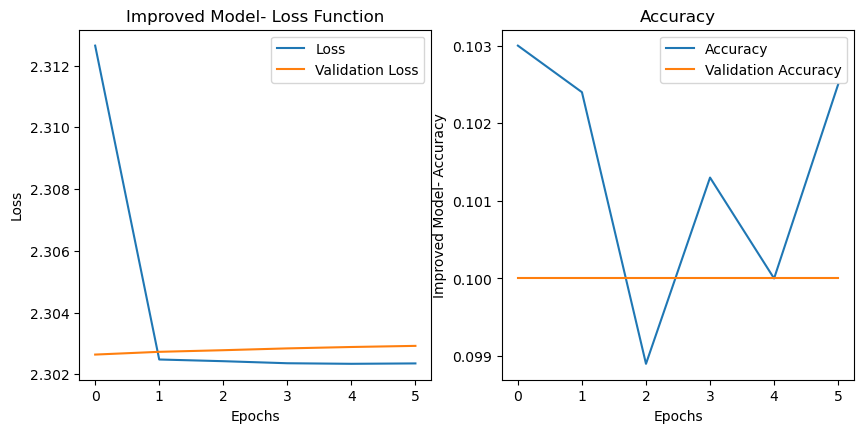

In [19]:
#Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy after model improvement: {test_accuracy:.2f}")
print(f"Test loss after model improvement: {test_loss:.2f}")

# Plot trainig and validation accuracy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_improved.history['loss'], label='Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')    # Y-axis label
plt.legend()
plt.title('Improved Model- Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_improved.history['accuracy'], label='Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Improved Model- Accuracy')  # Y-axis label
plt.legend()
plt.title('Accuracy')


# Fine-Tuning the ResNet50 Model
After training only the custom top layers, we unfreeze the entire ResNet50 model to let it adjust (fine-tune) its weights based on our specific CIFAR-10 dataset. This step helps the model learn more detailed and task-specific features. This improves accuracy by letting the entire model adapt to our images, not just the new top layers.





In [20]:
# Unfreeze the base model
base_model.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the entire model (ResNet + top layers)
history_fine_tuned = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images,
                    test_labels),
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 441ms/step - accuracy: 0.1425 - loss: 2.3141 - val_accuracy: 0.1000 - val_loss: 3.0205
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.3788 - loss: 1.7496 - val_accuracy: 0.1677 - val_loss: 2.3179
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 411ms/step - accuracy: 0.5416 - loss: 1.3869 - val_accuracy: 0.4863 - val_loss: 1.5182
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 417ms/step - accuracy: 0.6362 - loss: 1.1269 - val_accuracy: 0.6628 - val_loss: 1.0804
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 435ms/step - accuracy: 0.7227 - loss: 0.8916 - val_accuracy: 0.6726 - val_loss: 1.0498
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 424ms/step - accuracy: 0.7762 - loss: 0.7442 - val_accuracy: 0.6977 - val_loss: 1.0362
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 459ms/step - accuracy: 0.8129 - loss: 0.6276 - val_accuracy: 0.7009 - val_loss: 1.0291
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 438ms/step - accuracy: 0.8464 -

## Model Evaluation & Training Performance
We evaluate the model's generalization ability using the unseen test dataset:

Test Accuracy: Indicates how well the model performs on new, unseen data.

Test Loss: Shows the difference between predicted and actual labels — lower values mean better performance.

In [21]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy for Fine-Tuned Model: {test_accuracy:.2f}")
print(f"Test loss for Fine-Tuned Model: {test_loss:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7183 - loss: 1.0116
Test accuracy for Fine-Tuned Model: 0.72
Test loss for Fine-Tuned Model: 1.02


Also visualize the model’s training progress:

Loss Curve: Displays how the training and validation error reduced over time.

Accuracy Curve: Shows how the model's prediction accuracy improved across epochs.

Text(0.5, 1.0, 'Accuracy')

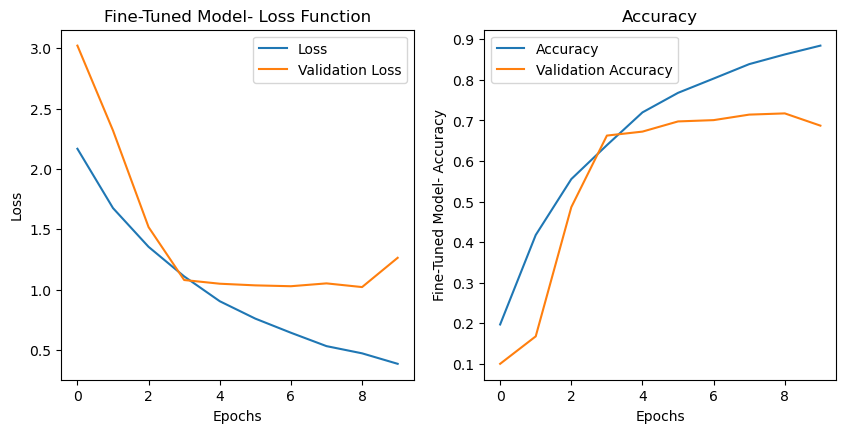

In [22]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_fine_tuned.history['loss'], label='Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')    # Y-axis label
plt.legend()
plt.title('Fine-Tuned Model- Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_fine_tuned.history['accuracy'], label='Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Fine-Tuned Model- Accuracy')  # Y-axis label
plt.legend()
plt.title('Accuracy')

# Fine-Tuning the ResNet50 Model: Improving Generalization
To help our model perform better on unseen data, we apply regularization techniques that reduce overfitting:

* Dropout: Randomly turns off some neurons during training to prevent the model from depending too much on specific ones. This makes the model more robust and better at generalizing.

* L1 Regularization: Encourages the model to have sparse weights (more zero values), which simplifies the model and helps in feature selection.

* L2 Regularization: Penalizes large weights, pushing the model toward smaller and smoother weights for better stability

In [23]:
# Unfreeze the base model
base_model.trainable = True

# Rebuild the model with Dropout and L2 regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    # First Dense layer with L2 regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Second Dense layer with L2 regularization
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),  # Another dropout layer

    # Output layer
    layers.Dense(10, activation='softmax')
])

# Re-compile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history_fine_tuned_2 = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[early_stop]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 457ms/step - accuracy: 0.5144 - loss: 1.9592 - val_accuracy: 0.7146 - val_loss: 1.4321
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 165s 528ms/step - accuracy: 0.8151 - loss: 0.9532 - val_accuracy: 0.7220 - val_loss: 1.4334
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 464ms/step - accuracy: 0.8428 - loss: 0.8857 - val_accuracy: 0.7259 - val_loss: 1.3771
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 454ms/step - accuracy: 0.8705 - loss: 0.7794 - val_accuracy: 0.7116 - val_loss: 1.5811
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 454ms/step - accuracy: 0.8930 - loss: 0.7077 - val_accuracy: 0.7333 - val_loss: 1.4595
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 465ms/step - accuracy: 0.9133 - loss: 0.6198 - val_accuracy: 0.7317 - val_loss: 1.4953


## Model Evaluation & Training Performance


In [24]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy for Fine-Tuned Model with Regularization: {test_accuracy:.2f}")
print(f"Test loss for Fine-Tuned Model with Regularization: {test_loss:.2f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7302 - loss: 1.3698
Test accuracy for Fine-Tuned Model with Regularization: 0.73
Test loss for Fine-Tuned Model with Regularization: 1.38


Text(0.5, 1.0, 'Accuracy')

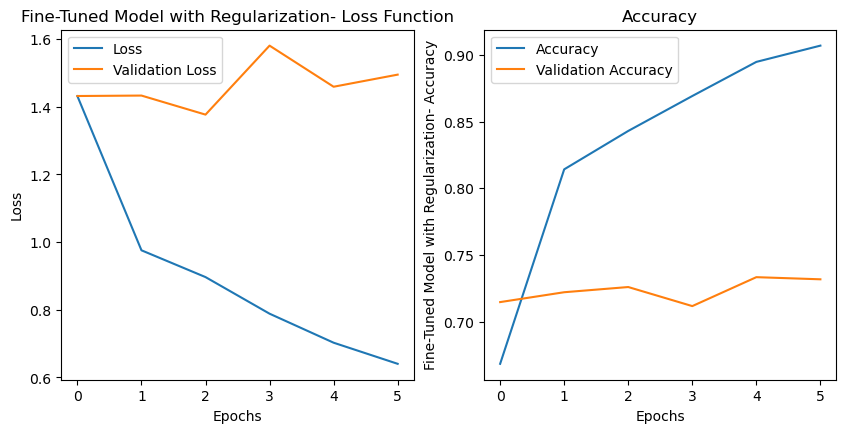

In [25]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_fine_tuned_2.history['loss'], label='Loss')
plt.plot(history_fine_tuned_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')    # Y-axis label
plt.legend()
plt.title('Fine-Tuned Model with Regularization- Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_fine_tuned_2.history['accuracy'], label='Accuracy')
plt.plot(history_fine_tuned_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Fine-Tuned Model with Regularization- Accuracy')  # Y-axis label
plt.legend()
plt.title('Accuracy')

### Confusion matrix and Classification Report
We summarize our model's performance using two evaluation tools:

* Classification Report: Shows precision, recall, f1-score for each class.

* Confusion Matrix: Shows how many times the model predicted correctly or incorrectly per class.





Show all the class names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Classification Report:

              precision    recall  f1-score   support

    airplane       0.75      0.77      0.76      1000
  automobile       0.82      0.82      0.82      1000
        bird       0.65      0.63      0.64      1000
         cat       0.54      0.59      0.56      1000
        deer       0.73      0.62      0.67      1000
         dog       0.70      0.56      0.63      1000
        frog       0.74      0.84      0.79      1000
       horse       0.74      0.82      0.78      1000
        ship       0.74      0.89      0.81      1000
       truck       0.88      0.72      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000



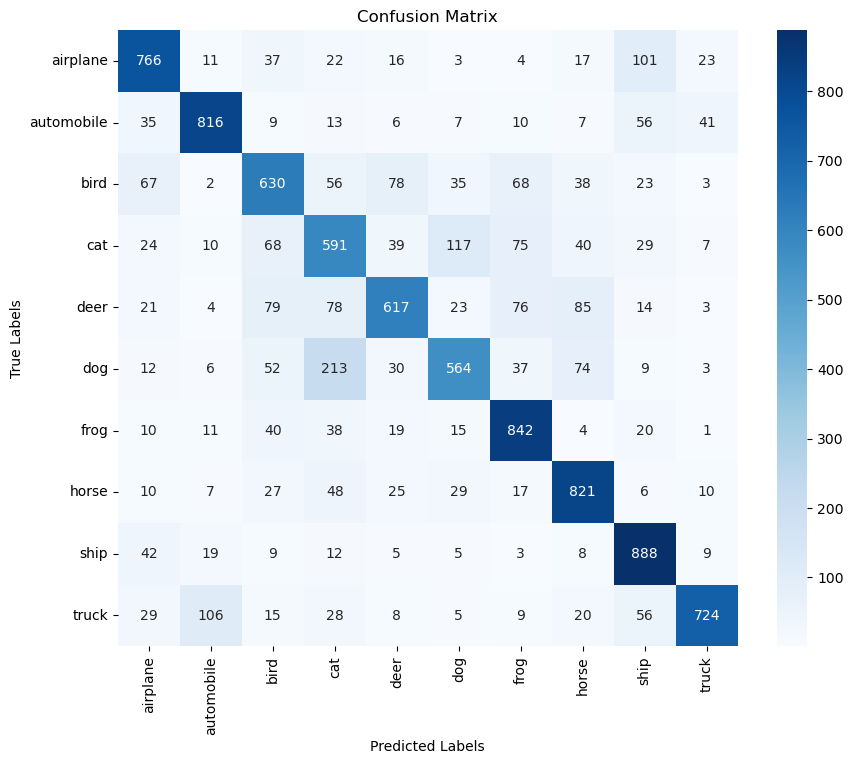

In [26]:
print('Show all the class names: ',class_name)

# Convert one-hot encoded labels back to integers
y_true = np.argmax(test_labels, axis=1)

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(test_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_name))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_name, yticklabels=class_name)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

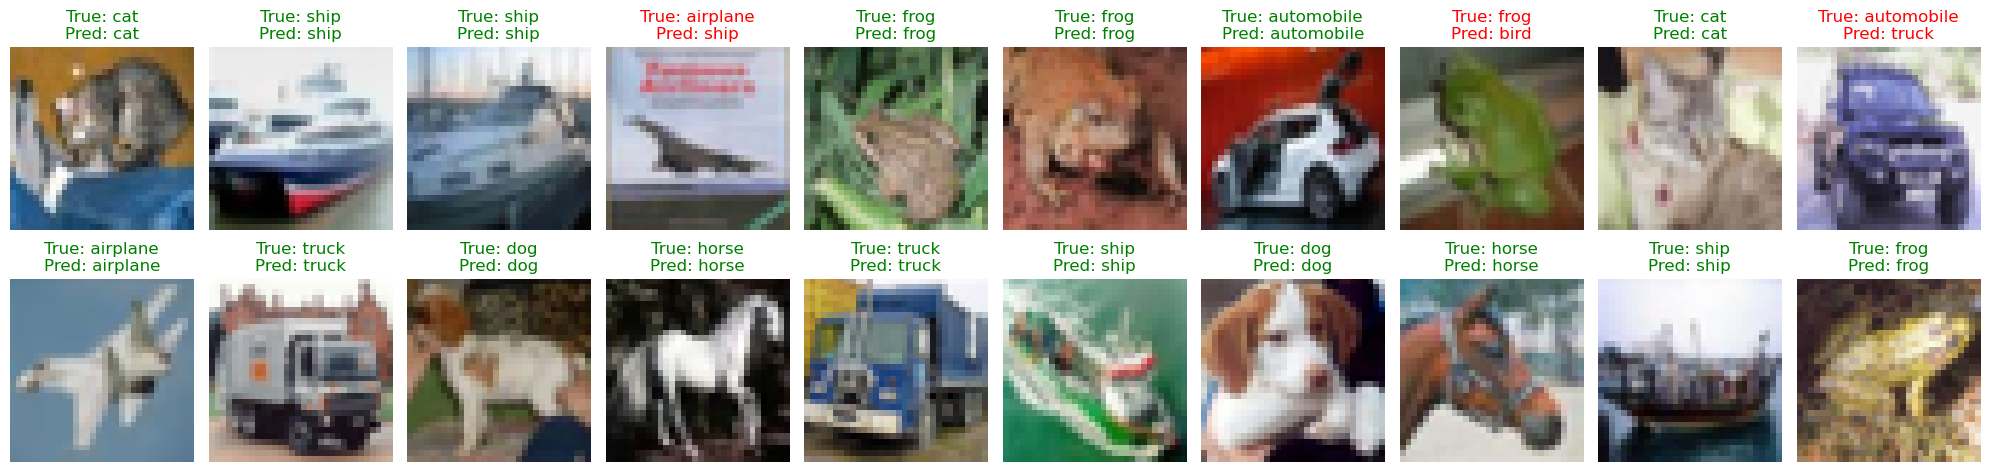

In [ ]:
# Displays test images with predicted vs. true labels (green = correct, red = incorrect).
# `num` sets how many to show; layout uses 2 rows; `class_names` maps label indices.


def show_predictions(images, y_true, y_pred, class_names, num=10):
    plt.figure(figsize=(20, 5))
    for i in range(num):
        plt.subplot(2, num//2, i+1)
        plt.imshow(images[i])
        color = 'green' if y_pred[i] == y_true[i] else 'red'
        plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
show_predictions(test_images, y_true, y_pred, class_names=class_name, num=20)


# Basic CNN Model

we build a basic Convolutional Neural Network (CNN) from scratch to classify CIFAR-10 images into 10 categories.



In [27]:
num_classes = 10
image_shape = (32,32, 3)

cnn_model = models.Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 32*32 it is 16*16
    Conv2D(filters=64,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,
    Conv2D(filters=128,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(num_classes,activation = 'softmax')

])

cnn_model.compile(loss ='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics =['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
history_basic = cnn_model.fit(
    train_images, train_labels, batch_size=64, epochs=30,
    verbose=1,
    validation_data=(test_images, test_labels),
)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.1334 - loss: 2.2653 - val_accuracy: 0.2382 - val_loss: 2.0227
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2935 - loss: 1.8963 - val_accuracy: 0.3839 - val_loss: 1.6598
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4243 - loss: 1.5737 - val_accuracy: 0.4624 - val_loss: 1.4504
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4665 - loss: 1.4578 - val_accuracy: 0.4729 - val_loss: 1.4577
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5139 - loss: 1.3592 - val_accuracy: 0.5078 - val_loss: 1.3409
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5387 - loss: 1.2812 - val_accuracy: 0.5411 - val_loss: 1.2773
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5719 - loss: 1.1955 - val_accuracy: 0.5474 - val_loss: 1.2655
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5991 - loss: 1.1126 - val_accu

In [29]:
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6262 - loss: 1.4314
Test accuracy: 0.63
Test loss: 1.43


Text(0.5, 1.0, 'Accuracy')

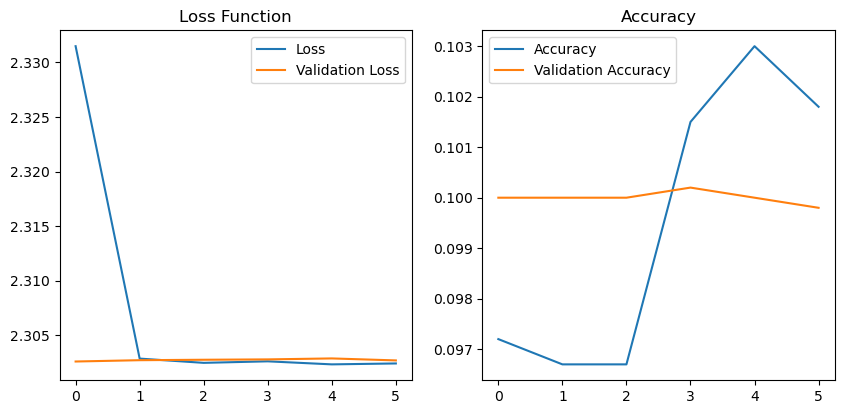

In [30]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Model Comparison Summary
This section summarizes the performance of different deep learning models evaluated for the image classification task.


### 1. **Base Model (ResNet50 Frozen)**
- **Test Accuracy**: 10%
- **Test Loss**: 2.30
- The base model used a pre-trained ResNet50 with frozen layers, meaning only the final classification head was trained.
- The low accuracy and high loss indicate the model failed to adapt to the new dataset, likely due to insufficient training of high-level features.

### 2. **Improved Model (Added Layers)**
- **Test Accuracy**: 10%
- **Test Loss**: 2.30
- Additional layers were appended to the frozen ResNet50, but without unfreezing any base layers, the results remained the same as the base model.
- This suggests that simply adding layers on top of a frozen backbone does not improve learning if feature extraction is inadequate.

### 3. **Fine-Tuned ResNet50**
- **Test Accuracy**: 72%
- **Test Loss**: 1.02
- Fine-tuning the ResNet50 (unfreezing some or all layers) significantly improved performance.
- The model was able to adapt the pretrained features to the target dataset, leading to a large boost in accuracy and a substantial drop in loss.

### 4. **Fine-Tuned ResNet50 + Regularization**
- **Test Accuracy**: 73%
- **Test Loss**: 1.37
- Incorporating regularization techniques (e.g., dropout, weight decay) slightly improved accuracy but increased the loss.
- The increase in loss might be due to regularization penalizing large weights, which can make predictions more conservative, though better generalized.


### 5. **Custom CNN**
- **Test Accuracy**: 63%
- **Test Loss**: 1.43
- A custom convolutional neural network built from scratch performed reasonably well, outperforming the frozen ResNet50 models but underperforming compared to the fine-tuned ones.
- This model demonstrates decent generalization but lacks the deep feature extraction capabilities of pretrained architectures.

## **Conclusion**
Fine-tuning the ResNet50 model yielded the best overall performance, making it the most effective approach in this experiment. Regularization offered a marginal improvement in accuracy but came with increased loss, suggesting a trade-off between generalization and confidence. Custom architectures, while flexible, did not outperform transfer learning-based models in this case.